In [22]:
import requests
import zipfile
import os
import pandas as pd
import yfinance as yf
import warnings
import time
import pandas as pd
import numpy as np
import torch

# 讀取股票總覽

In [23]:
df = pd.read_csv('/hpcdata/ccc1013/衍盛筆試/Earnings_distribution/股票總覽.csv')
# 確保索引是日期格式
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
df.drop(df.columns[0], axis=1, inplace=True)

# 建立multiindex的dataframe

In [24]:
# 取得原本的股票代號
stocks = df.columns

# 定義 MultiIndex，確保 `metrics` 在內層
metrics = ["PRICE","P/E", "Return", "DY", "EPS", "現金股利"]  # 兩個指標 # DY Dividend Yield
multi_index = pd.MultiIndex.from_product([stocks, metrics], names=["Stock", "Metric"])


# 建立新 DataFrame，先讓 EPS 為 NaN
df_multi = pd.DataFrame(index=df.index, columns=multi_index)
for stock in stocks:
    df_multi.loc[:, (stock, 'PRICE')] = df[stock]
    

In [ ]:
U = df_multi.loc[:, (slice(None), 'PRICE')].pct_change()
U = U.rename(columns=lambda x: 'Return' if x == 'PRICE' else x, level='Metric')
df_multi.loc[:, (slice(None), 'Return')] = U
df_multi = df_multi.loc['2014-01':'2024-12']


# 將EPS以及現金股利填入

In [26]:
for year in range(2013, 2024):
    print(year)
    nxt_year = year+1

    profit_dist_df = pd.read_csv(f'/hpcdata/ccc1013/衍盛筆試/Earnings_distribution/盈餘分配({year}).csv')
    profit_dist_df['代號'] = profit_dist_df['代號'].map(str)
    profit_dist_df.set_index('代號', inplace=True)
    stock_list = list(profit_dist_df.index)


    for stock in stock_list:
        df_multi.loc[f"{nxt_year}-01":f"{nxt_year}-12", (stock, 'EPS')] = profit_dist_df.loc[stock, '所屬EPS']
    
    for stock in stock_list:
        df_multi.loc[f"{nxt_year}-01":f"{nxt_year}-12", (stock, '現金股利')] = profit_dist_df.loc[stock, '現金股利']
    


2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


# 製作完整Multiindex Dataframe的數據

In [27]:
# 計算 P/E Ratio # DY = Dividend Yield
price = df_multi.xs('PRICE', level=1, axis=1)
eps = df_multi.xs('EPS', level=1, axis=1)
cash = df_multi.xs('現金股利', level=1, axis=1)

U = price / eps  # 計算 P/E Ratio
W = cash / price

# 設定新的 MultiIndex，讓 `P/E` 成為 Metrics
U.columns = pd.MultiIndex.from_tuples([(col, 'P/E') for col in U.columns])
W.columns = pd.MultiIndex.from_tuples([(col, 'DY') for col in W.columns])

df_multi.loc[:, (slice(None), 'P/E')] = U
df_multi.loc[:, (slice(None), 'DY')] = W

df_multi = df_multi.drop(columns=df_multi.columns[df_multi.columns.get_level_values(1) == "現金股利"])
df_multi = df_multi.drop(columns=df_multi.columns[df_multi.columns.get_level_values(1) == "PRICE"])
df_multi = df_multi.drop(columns=df_multi.columns[df_multi.columns.get_level_values(1) == "EPS"])

df_multi 


Stock             1240                           1336                      \
Metric             P/E    Return        DY        P/E    Return        DY   
Date                                                                        
2014-01-02         NaN       NaN       NaN        NaN  0.004717       NaN   
2014-01-03         NaN       NaN       NaN        NaN -0.004695       NaN   
2014-01-06         NaN       NaN       NaN        NaN  0.014151       NaN   
2014-01-07         NaN       NaN       NaN        NaN  0.018605       NaN   
2014-01-08         NaN       NaN       NaN        NaN       0.0       NaN   
...                ...       ...       ...        ...       ...       ...   
2024-12-25       375.0  0.009615  0.019048  12.268292  0.012072  0.016302   
2024-12-26  370.714297 -0.011429  0.019268  12.341463  0.005964  0.016206   
2024-12-27  371.428571  0.001927  0.019231  12.243903 -0.007905  0.016335   
2024-12-30  371.428571       0.0  0.019231       12.0  -0.01992  0.016667   
2024-12-31  372.857148  0.003846  0.019157  12.048781  0.004065  0.016599   

Stock            1580                            1586  ...      9933  \
Metric            P/E    Return        DY         P/E  ...        DY   
Date                                                   ...             
2014-01-02   7.976597 -0.006349  0.093358  140.627146  ...   0.10385   
2014-01-03   7.849175 -0.015975  0.094874  139.364004  ...  0.104181   
2014-01-06   7.696269 -0.019481  0.096759  133.048427  ...  0.106441   
2014-01-07   7.645301 -0.006622  0.097404   132.62738  ...  0.106096   
2014-01-08   7.772723  0.016667  0.095807  128.417003  ...  0.106326   
...               ...       ...       ...         ...  ...       ...   
2024-12-25  21.791045       0.0  0.041096   52.358491  ...  0.047619   
2024-12-26  21.716418 -0.003425  0.041237   52.358491  ...  0.047679   
2024-12-27  21.865672  0.006873  0.040956   51.981131  ...  0.048101   
2024-12-30  21.940299  0.003413  0.040816   51.698112  ...  0.048718   
2024-12-31  22.014925  0.003401  0.040678   51.698112  ...  0.049223   

Stock           9941                           9946                      \
Metric           P/E    Return        DY        P/E    Return        DY   
Date                                                                      
2014-01-02  5.166272 -0.010256  0.115589   6.642715  0.015101  0.143635   
2014-01-03  5.092659 -0.014249   0.11726   6.609776 -0.004959  0.144351   
2014-01-06  5.099352  0.001314  0.117106    6.45606 -0.023256  0.147788   
2014-01-07  5.085967 -0.002625  0.117414   6.445081 -0.001701   0.14804   
2014-01-08  5.099352  0.002632  0.117106   6.488999  0.006814  0.147038   
...              ...       ...       ...        ...       ...       ...   
2024-12-25  8.333333 -0.014706  0.055721  54.999999  0.023809  0.018182   
2024-12-26  8.416252   0.00995  0.055172   53.95349 -0.019027  0.018534   
2024-12-27   8.58209  0.019704  0.054106  52.093022 -0.034483  0.019196   
2024-12-30  8.706468  0.014493  0.053333  53.255813  0.022321  0.018777   
2024-12-31  8.623549 -0.009524  0.053846   52.55814   -0.0131  0.019027   

Stock            9955                      
Metric            P/E    Return        DY  
Date                                       
2014-01-02  46.382977  0.030733  0.013761  
2014-01-03  46.595744  0.004587  0.013699  
2014-01-06  46.489363 -0.002283   0.01373  
2014-01-07  46.702129  0.004577  0.013667  
2014-01-08  46.595744 -0.002278  0.013699  
...               ...       ...       ...  
2024-12-25        NaN   0.01773       NaN  
2024-12-26        NaN  0.001742       NaN  
2024-12-27        NaN -0.010435       NaN  
2024-12-30        NaN  0.008787       NaN  
2024-12-31        NaN -0.006969       NaN  

[2682 rows x 5616 columns]

# 建立各種不同功能的class，以獲得用於訓練的因子batch以及label

In [64]:
class LabelBatch:
    def __init__(self, batch_list):
        self.label_list = self._get_label_list(batch_list)

    def _get_label_list(self, batch_list):
        _label_list = []
        for batch in batch_list:
            
            length = len(batch)
            segments = 10  # 分成 10 等分
            segment_size = length // segments  # 每份大小 (884 // 10 = 88)
            remaining = length % segments  # 計算餘數 (884 % 10 = 4)
            
            labels = np.concatenate([np.full(segment_size, 9 - i) for i in range(segments)])
            
            # 補齊剩下的(補 0)
            labels = np.concatenate([labels, np.full(remaining, 0)])
            labels = torch.from_numpy(labels)
            
            _label_list.append(labels)
        return _label_list

In [65]:
class FactorBatch:
    def __init__(self, time_interval_list, Type):
        if Type=='train':
            self.batch_list = self._get_train_batch_list(time_interval_list)
        if Type=='test':
            self.batch_list = self._get_train_batch_list(time_interval_list)
        if Type=='valid':
            self.batch_list = self._get_train_batch_list(time_interval_list)

    def _get_test_batch_list(self, time_interval_list):
        _batch_list = []
        for idx in range(1,len(time_interval_list)):
            l_start, l_end = time_interval_list[idx-1]
            c_start, c_end = time_interval_list[idx]
            df_filtered = df_multi.loc[c_start : c_end] #篩選範圍
            
            stocks_with_nan = df_filtered.columns.get_level_values('Stock')[df_filtered.isna().any()] # 找出至少有一個 NaN 的 `Stock`
            df_filtered = df_filtered.drop(columns=stocks_with_nan, level='Stock') #並且移除
            #print(df_filtered)
            min_trade_days = 71 # 每四個月的最少交易日

            COLUMNS = df_filtered.columns.get_level_values('Stock')
            COLUMNS = list(set(COLUMNS))
            single_batch = np.array([df_filtered[col].values.astype(float)[:min_trade_days, ] # 讓資料長度一致，方便丟入模型
                                     for col in COLUMNS])
            
            single_batch_tensor = torch.from_numpy(single_batch).float().permute(0,2,1)
            _batch_list.append(single_batch_tensor)
        return _batch_list
        

    def _get_train_batch_list(self, time_interval_list):
        _batch_list = []
        for idx in range(len(time_interval_list)-1):
            c_start, c_end = time_interval_list[idx]
            n_start, n_end = time_interval_list[idx+1]
            df_filtered = df_multi.loc[c_start : n_end] #篩選範圍
            
            stocks_with_nan = df_filtered.columns.get_level_values('Stock')[df_filtered.isna().any()] # 找出至少有一個 NaN 的 `Stock`
            df_filtered = df_filtered.drop(columns=stocks_with_nan, level='Stock') #並且移除
            
            df_return = df_filtered.loc[n_start : n_end].xs('Return', level='Metric', axis=1) #篩選出報酬率
            df_return = df_return*252 # 放大避免單日報酬率太小
            std_values = df_return.std(axis=0) #計算標準差
            std_values = std_values.mask(std_values == 0, np.nan)
            
            sharpe_ratio = df_return.mean(axis=0) / std_values #計算夏普值
            sharpe_ratio = sharpe_ratio.dropna().sort_values(ascending=False)

            df_filtered = df_filtered[sharpe_ratio.index] # 有排序(Sharpe ratio高的在前面)
            df_filtered = df_filtered.loc[c_start : c_end]
        
            min_trade_days = 71 # 每四個月的最少交易日
            single_batch = np.array([df_filtered[col].values.astype(float)[:min_trade_days, ] # 讓資料長度一致，方便丟入模型
                                     for col in sharpe_ratio.index])
            
            single_batch_tensor = torch.from_numpy(single_batch).float().permute(0,2,1)
            _batch_list.append(single_batch_tensor)
        return _batch_list  

In [75]:
class TimeInterval:
    def __init__(self, Type):
        if Type=='train':
            self.time_interval_list = self._get_train_time_interval()
        if Type=='test':
            self.time_interval_list = self._get_test_time_interval()
        if Type=='valid':
            self.time_interval_list = self._get_valid_time_interval()

    def _get_valid_time_interval(self):
        valid_time_interval_list = []
        for year in range(2019,2020):
            valid_time_interval_list.append((f'{year}-01', f'{year}-04'))
            valid_time_interval_list.append((f'{year}-05', f'{year}-08'))
            valid_time_interval_list.append((f'{year}-09', f'{year}-12'))
        valid_time_interval_list 
        return valid_time_interval_list
        
            
    def _get_train_time_interval(self):
        train_time_interval_list = []
        for year in range(2014,2019):
            train_time_interval_list.append((f'{year}-01', f'{year}-04'))
            train_time_interval_list.append((f'{year}-05', f'{year}-08'))
            train_time_interval_list.append((f'{year}-09', f'{year}-12'))
        train_time_interval_list.append(('2020-01','2020-04'))
        return train_time_interval_list
        
    def _get_test_time_interval(self):
        test_time_interval_list = []
        test_time_interval_list.append(('2019-09','2019-12'))
        for year in range(2020,2025):
            test_time_interval_list.append((f'{year}-01', f'{year}-04'))
            test_time_interval_list.append((f'{year}-05', f'{year}-08'))
            test_time_interval_list.append((f'{year}-09', f'{year}-12'))
        return test_time_interval_list

In [76]:
class FactorDataset:
    def __init__(self, Type):
        self.time_interval_list = TimeInterval(Type).time_interval_list
        factor_batch = FactorBatch(self.time_interval_list, Type)
        self.batch_list = factor_batch.batch_list

        label_batch = LabelBatch(self.batch_list)
        self.label_list = label_batch.label_list

In [53]:
train_set = FactorDataset('train')
valid_set = FactorDataset('valid')
test_set = FactorDataset('test')

# 建立 1d CNN模型

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim

class OneDimCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(OneDimCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(32)

        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.pool = nn.AdaptiveAvgPool1d(1)  # 壓縮時間維度
        self.fc = nn.Linear(64, num_classes)  # 全連接層輸出 10 類別
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x).squeeze(-1)  # 壓縮時間維度
        x = self.fc(x)  # 輸出分類結果
        return x

# 測試模型
model = OneDimCNN(num_classes=10)
x = torch.randn(32, 3, 71)  # (batch_size=32, channels=4, sequence_length=71)
output = model(x)

print(output.shape)  # 應該是 (32, 10)


torch.Size([32, 10])


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleOneDimCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleOneDimCNN, self).__init__()
        
        # 1D 卷積：輸入 channel=4，輸出 channel=16
        self.conv = nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm1d(8)
        self.relu = nn.ReLU()

        # 自動將序列長度壓縮為 1
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        # 全連接層，將 channel=16 壓縮到 num_classes
        self.fc = nn.Linear(8, num_classes)
        
    def forward(self, x):
        x = self.conv(x)         # (batch_size, 16, seq_len)
        x = self.bn(x)           # BatchNorm
        x = self.relu(x)         # ReLU
        x = self.pool(x).squeeze(-1)  # 壓縮維度 -> (batch_size, 16)
        x = self.fc(x)           # (batch_size, 10)
        return x


model = SimpleOneDimCNN(num_classes=10)
x = torch.randn(32, 3, 71)  # (batch_size=32, channels=4, sequence_length=71)
output = model(x)
print(output.shape)  # 預期 (32, 10)


torch.Size([32, 10])


# 設置各種hyper-parameter

In [129]:
EPOCH = 10  # 假設要訓練100個epoch
# 損失函數 & 優化器
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)


device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# 建立模型

#model = OneDimCNN(num_classes=10)
model = SimpleOneDimCNN()
model = model.to(device)


# 開始訓練並且儲存模型

In [130]:
for epoch in range(EPOCH):
    ############################
    #         Training         #
    ############################
    model.train()  # 開啟訓練模式(啟用BN、Dropout等)
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for idx in range(len(train_set.batch_list)):
        feats = train_set.batch_list[idx].to(device)
        labels = train_set.label_list[idx].to(device)

        step = 64
        for j in range(len(feats)//step):
            seg_feats = feats[step*j : step*(j+1)]
            seg_labels = labels[step*j : step*(j+1)]

            optimizer.zero_grad()
            preds = model(seg_feats)  
            loss = criterion(preds, seg_labels)
        
            # 反向傳播與參數更新
            loss.backward()
            optimizer.step()

            # 累計訓練損失
            train_running_loss += loss.item()

            # 計算訓練準確率
            predicted = torch.argmax(preds, dim=1)
            train_correct += (predicted == seg_labels).sum().item()
            train_total += seg_labels.size(0)

    # 計算平均訓練損失、訓練正確率
    avg_train_loss = train_running_loss / len(train_set.batch_list)
    train_acc = train_correct / train_total

    ############################
    #       Validation         #
    ############################
    model.eval()  # 關閉訓練模式(停止BN更新、停用Dropout等)
    valid_running_loss = 0.0
    valid_correct = 0
    valid_total = 0
    
    with torch.no_grad():  # 在驗證集不需計算梯度
        for idx in range(len(valid_set.batch_list)):
            feats = valid_set.batch_list[idx].to(device)
            labels = valid_set.label_list[idx].to(device)

            preds = model(feats)
            loss = criterion(preds, labels)
            
            # 累計驗證損失
            valid_running_loss += loss.item()
            
            # 計算驗證準確率
            predicted = torch.argmax(preds, dim=1)
            valid_correct += (predicted == labels).sum().item()
            valid_total += labels.size(0)

    # 計算平均驗證損失、驗證正確率
    avg_valid_loss = valid_running_loss / len(valid_set.batch_list)
    valid_acc = valid_correct / valid_total

    # 輸出本 epoch 結果
    """
    print(f"Epoch [{epoch+1}/{EPOCH}] "
          f"Train Loss: {avg_train_loss:.4f} | Train ACC: {train_acc:.4f} "
          f"Val Loss: {avg_valid_loss:.4f} | Val ACC: {valid_acc:.4f}")
    """
    if epoch%10==0:
        print(f"Epoch [{epoch+1}/{EPOCH}] "
              f"Train Loss: {avg_train_loss} | Train ACC: {train_acc} "
              f"Val Loss: {avg_valid_loss} | Val ACC: {valid_acc}")


Epoch [1/10] Train Loss: 39.93553347587586 | Train ACC: 0.1013764880952381 Val Loss: 2.3473209540049234 | Val ACC: 0.09982486865148861


In [123]:
torch.save(model.state_dict(), "model.pth")
print("模型已儲存！")

模型已儲存！


# 載入模型並且開始回測

In [122]:
model = SimpleOneDimCNN(num_classes=10)  # 重新建立模型
model.load_state_dict(torch.load("model.pth", weights_only=True))
model.eval()  # 切換為推論模式
print("模型已載入！")

模型已載入！


In [181]:
model.eval()  # 切換為評估模式
return_df_list =[]

for idx in range(1,len(test_set.time_interval_list)):
    l_start, l_end = test_set.time_interval_list[idx-1]
    c_start, c_end = test_set.time_interval_list[idx]
    with torch.no_grad():  # 禁用梯度計算，加速運算並節省記憶體
        batch = test_set.batch_list[idx-1].to(device)
        output = model(batch)
        prob_tensor = output[:, -1]
        top_values, top_indices = torch.topk(prob_tensor, k=15)
        top_indices = top_indices.cpu().numpy()

    
    df_filtered = df_multi.loc[l_start : c_end] #篩選範圍
            
    stocks_with_nan = df_filtered.columns.get_level_values('Stock')[df_filtered.isna().any()] # 找出至少有一個 NaN 的 `Stock`
    df_filtered = df_filtered.drop(columns=stocks_with_nan, level='Stock') #並且移除

    selected_stocks = df_filtered.columns.get_level_values('Stock').unique()[top_indices]
    df_filtered = df_filtered.loc[c_start : c_end , (selected_stocks, 'Return')]
    return_df = df_filtered.mean(axis=1)
    return_df_list.append(return_df)

final_return_df = pd.concat(return_df_list, axis=0)

In [182]:
VIX = yf.download('^VIX', '2019-12-31','2024-12-31')['Close']
VIX = VIX.shift(1).dropna()
final_return_df = pd.concat([final_return_df , VIX], axis=1)
final_return_df.columns = ['return', 'VIX']
final_return_df["VIX"] = final_return_df["VIX"].fillna(-1)
final_return_df['return'] = final_return_df.apply(lambda row: row['return'] * (-1) if row['VIX'] > 25 else row['return'], axis=1)

final_return_df = final_return_df['return'].dropna()

[*********************100%***********************]  1 of 1 completed


# 查看回測結果

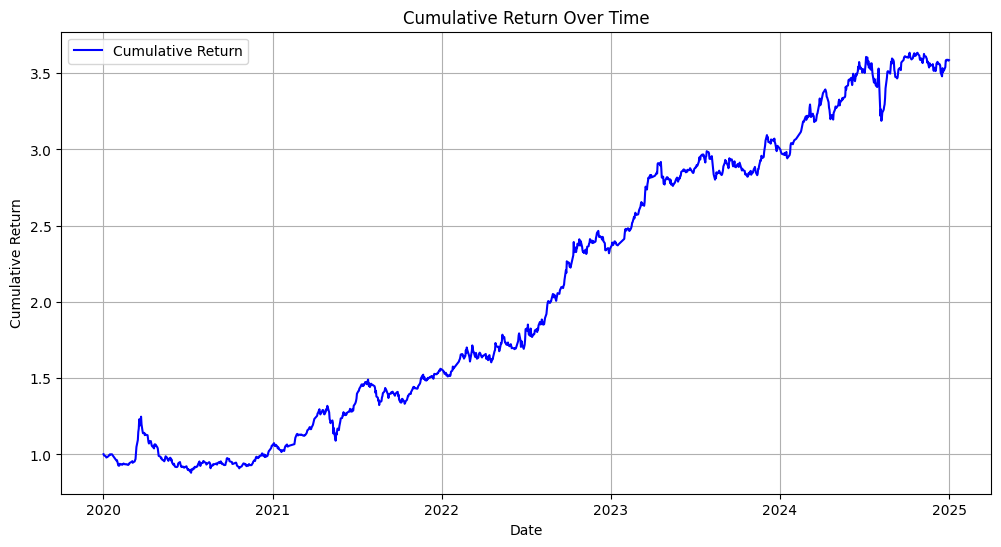

In [183]:
import matplotlib.pyplot as plt
import pandas as pd
final_return_df = final_return_df.astype(float)

# 計算累計報酬
cumulative_return = (final_return_df + 1).cumprod()

# 繪製累計報酬曲線
plt.figure(figsize=(12, 6))
plt.plot(cumulative_return, label="Cumulative Return", color='blue')
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Return Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [184]:
mean = final_return_df.values.mean()
std = final_return_df.values.std()
sharpe_ratio = mean/std*np.sqrt(252)

annul_return = cumulative_return.values[-1]**(1/5)-1
annul_return = annul_return*100

print(f'sharpe ratio  = {sharpe_ratio:.2f}')
print(f'annual return = {annul_return:.1f}%')

sharpe ratio  = 1.66
annual return = 29.1%


# 與大盤做比較(0050)

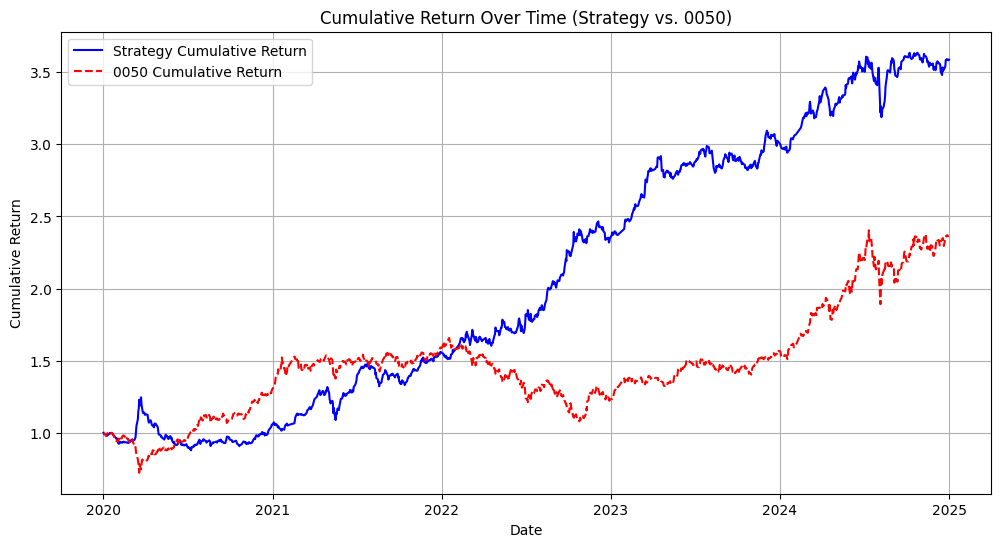

Strategy Sharpe Ratio  = 1.66
Strategy Annual Return = 29.1%
0050 Sharpe Ratio  = 0.96
0050 Annual Return = 18.71%


In [187]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import yfinance as yf
import pandas as pd

#下載 0050 的歷史股價
etf_0050 = yf.download("0050.TW", start="2020-01-01", end="2024-12-31", progress = False)

# 計算日報酬率 (Daily Return)
etf_0050["Return"] = etf_0050["Adj Close"].pct_change()

# 選擇日報酬率作為分析數據
etf_0050_return = etf_0050["Return"].dropna()

# **確保 `final_return_df` 為 `float`**
final_return_df = final_return_df.astype(float)
etf_0050_return = etf_0050_return.astype(float)  # 假設 `etf_0050_return` 為 0050 的日報酬

# **計算累計報酬**
cumulative_return = (final_return_df + 1).cumprod()
cumulative_etf_0050 = (etf_0050_return + 1).cumprod()

# **繪製累計報酬曲線**
plt.figure(figsize=(12, 6))
plt.plot(cumulative_return, label="Strategy Cumulative Return", color='blue')
plt.plot(cumulative_etf_0050, label="0050 Cumulative Return", color='red', linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Return Over Time (Strategy vs. 0050)")
plt.legend()
plt.grid(True)
plt.show()

# **計算 Sharpe Ratio**
mean = final_return_df.mean()
std = final_return_df.std()
sharpe_ratio = mean / std * np.sqrt(252)

mean_etf = etf_0050_return.mean()
std_etf = etf_0050_return.std()
sharpe_ratio_etf = mean_etf / std_etf * np.sqrt(252)

# **計算年化報酬 (Annualized Return)**
annul_return = cumulative_return.values[-1]**(1/5) - 1  
annul_return = round(annul_return * 100, 2)

annul_return_etf = cumulative_etf_0050.values[-1]**(1/5) - 1
annul_return_etf = round(annul_return_etf * 100, 2)

# **輸出結果**
print(f"Strategy Sharpe Ratio  = {sharpe_ratio:.2f}")
print(f"Strategy Annual Return = {annul_return}%")
print(f"0050 Sharpe Ratio  = {sharpe_ratio_etf:.2f}")
print(f"0050 Annual Return = {annul_return_etf}%")
